In [12]:
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('apw-notebook')
%matplotlib inline
from scipy.interpolate import interp1d

from ebak import SimulatedRVOrbit
from ebak.singleline import RVData
from ebak.sampler import (design_matrix, sinusoid_model, period_grid, tensor_vector_scalar, 
                          marginal_ln_likelihood, sample_posterior)

## Working in units of [day, km/s], generate some fake data:

In [52]:
np.random.seed(42)
n_data = 9

n_terms = 1
true_p = np.array([-131.2, 3., 0.1])
true_P = 53.1 # days

t = np.full(n_data, 56712.) + np.random.uniform(0, 32, n_data)*true_P
rv = sinusoid_model(true_p, t, true_P)

sigma = np.ones_like(t) * 0.3 # typical uncertainty
rv += np.random.normal(0, sigma)

inv_var = 1 / sigma**2

data = RVData(t, rv*u.km/u.s, ivar=inv_var/(u.km/u.s)**2)

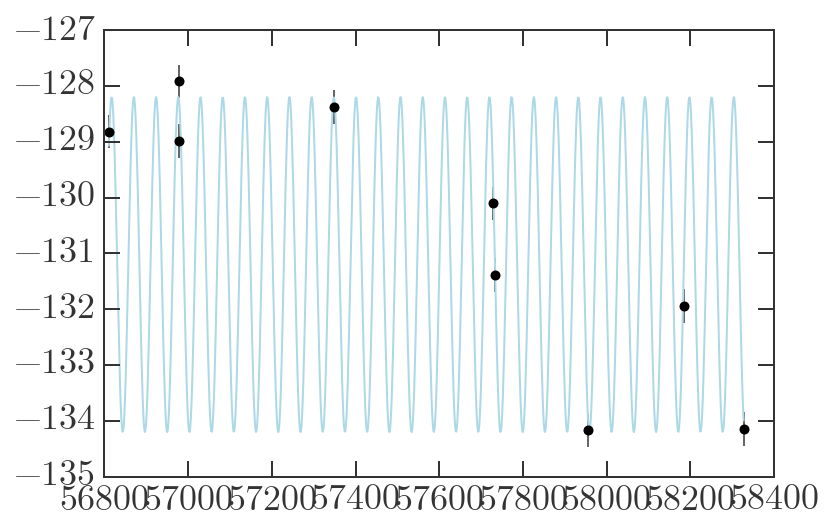

In [53]:
# plot the curve for the true model
_t = np.linspace(t.min(), t.max(), 1024)
plt.plot(_t, sinusoid_model(true_p, _t, true_P), marker=None, color='lightblue')
data.plot(ax=plt.gca())

## Grid in periods

The claim for period spacing: 
$$
dP = \frac{P^2}{2\pi T_{\rm max}}
$$

In [54]:
P_grid, dP_grid = period_grid(data, resolution=2, P_min=10.)

The model: 
$$
\sum_{k=1}^1 \left[a_k \cos\left(\frac{2\pi k t}{P}\right) + b_k \sin\left(\frac{2\pi k t}{P}\right)\right] + v_0
$$

In [55]:
marginal_ln_likelihood(53., data)

18.815179440678662

In [56]:
marg_ln_likes = np.array([marginal_ln_likelihood(P, data) for P in P_grid])

(10.0, 10718.184509358589)

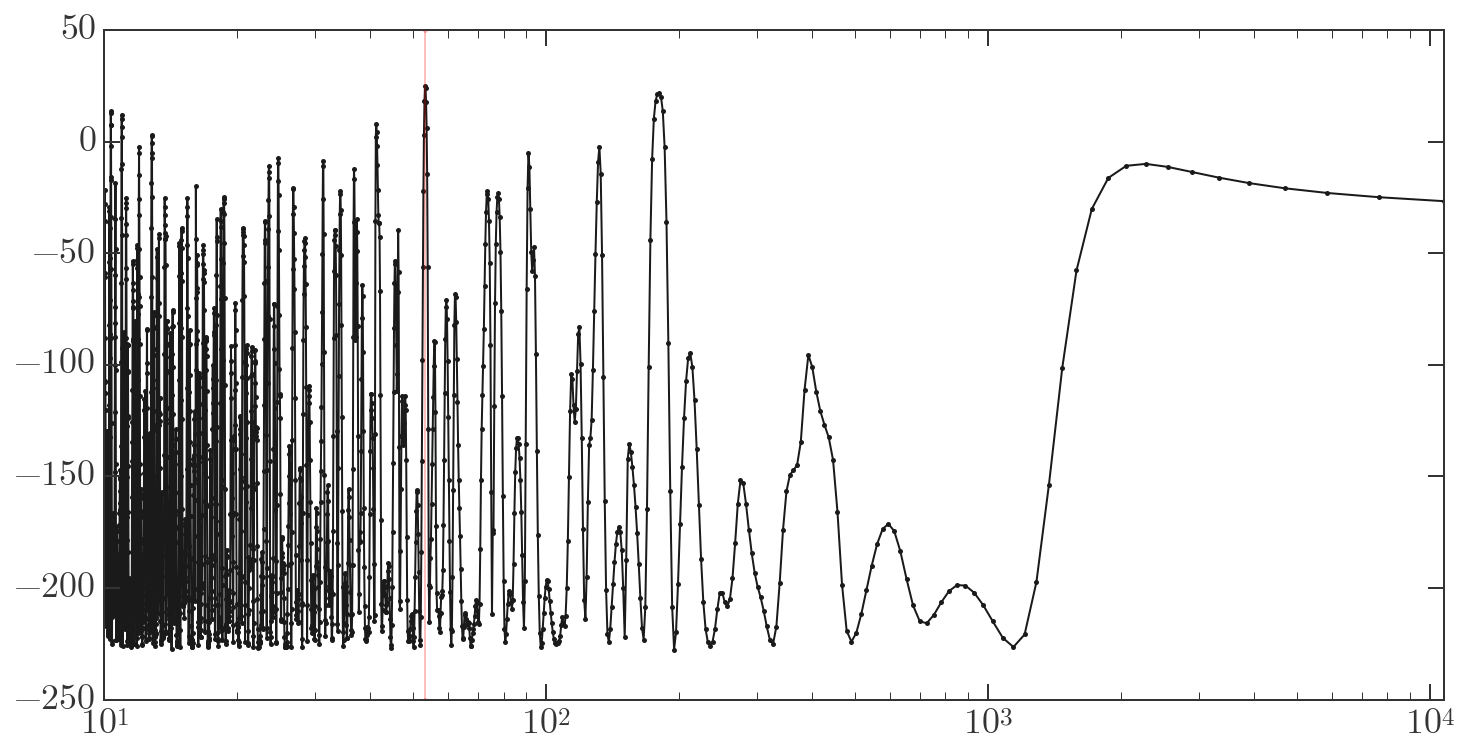

In [57]:
plt.figure(figsize=(12,6))
plt.semilogx(P_grid, marg_ln_likes)
plt.axvline(true_P, color='r', alpha=0.25)
plt.xlim(P_grid.min(), P_grid.max())
# plt.xlim(1.4, 1.45)

In [58]:
# assuming prior on periods flat in ln(P)
probs = np.exp(marg_ln_likes - marg_ln_likes.max()) * dP_grid / P_grid

(1e-09, 1.0)

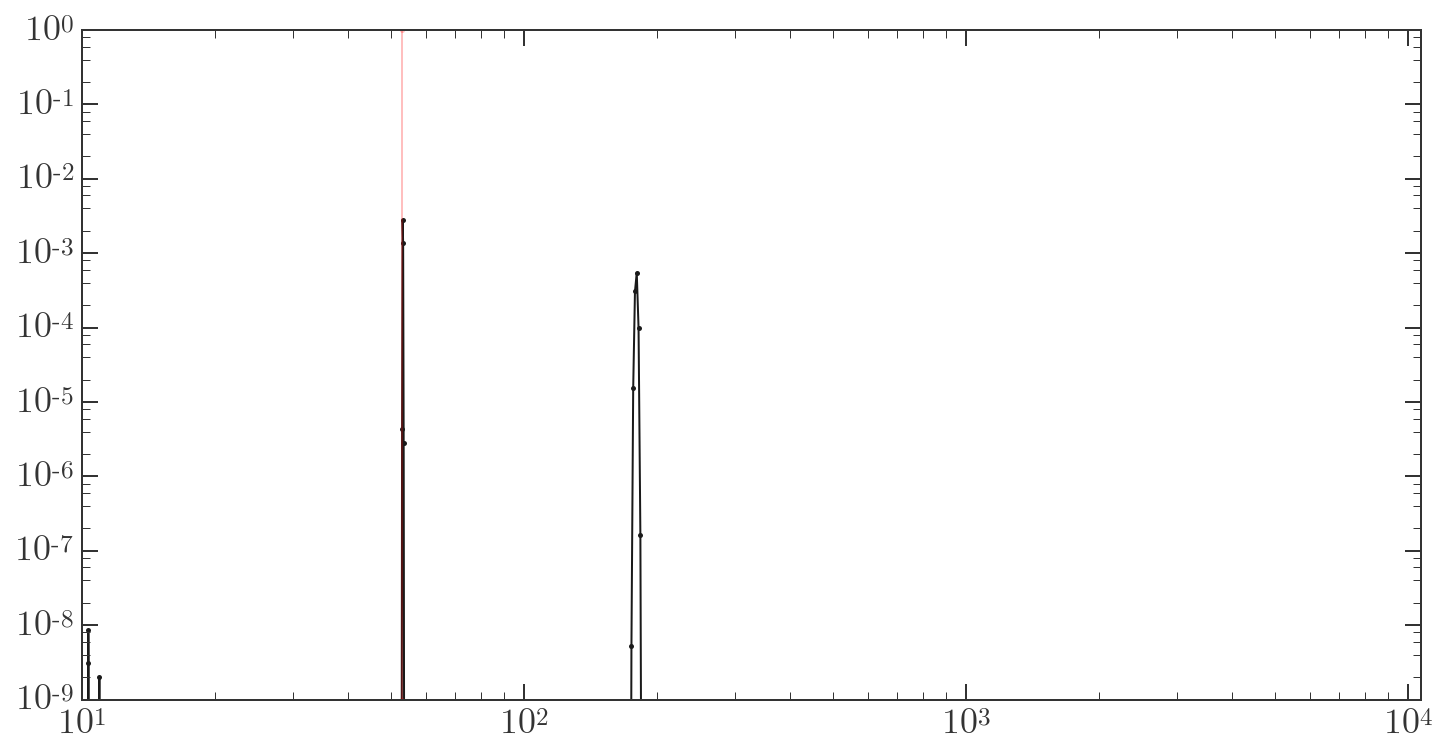

In [59]:
plt.figure(figsize=(12,6))
plt.loglog(P_grid, probs)
plt.axvline(true_P, color='r', alpha=0.25)
plt.xlim(P_grid.min(), P_grid.max())
plt.ylim(1E-9, 1E0)

(10.0, 10718.184509358589)

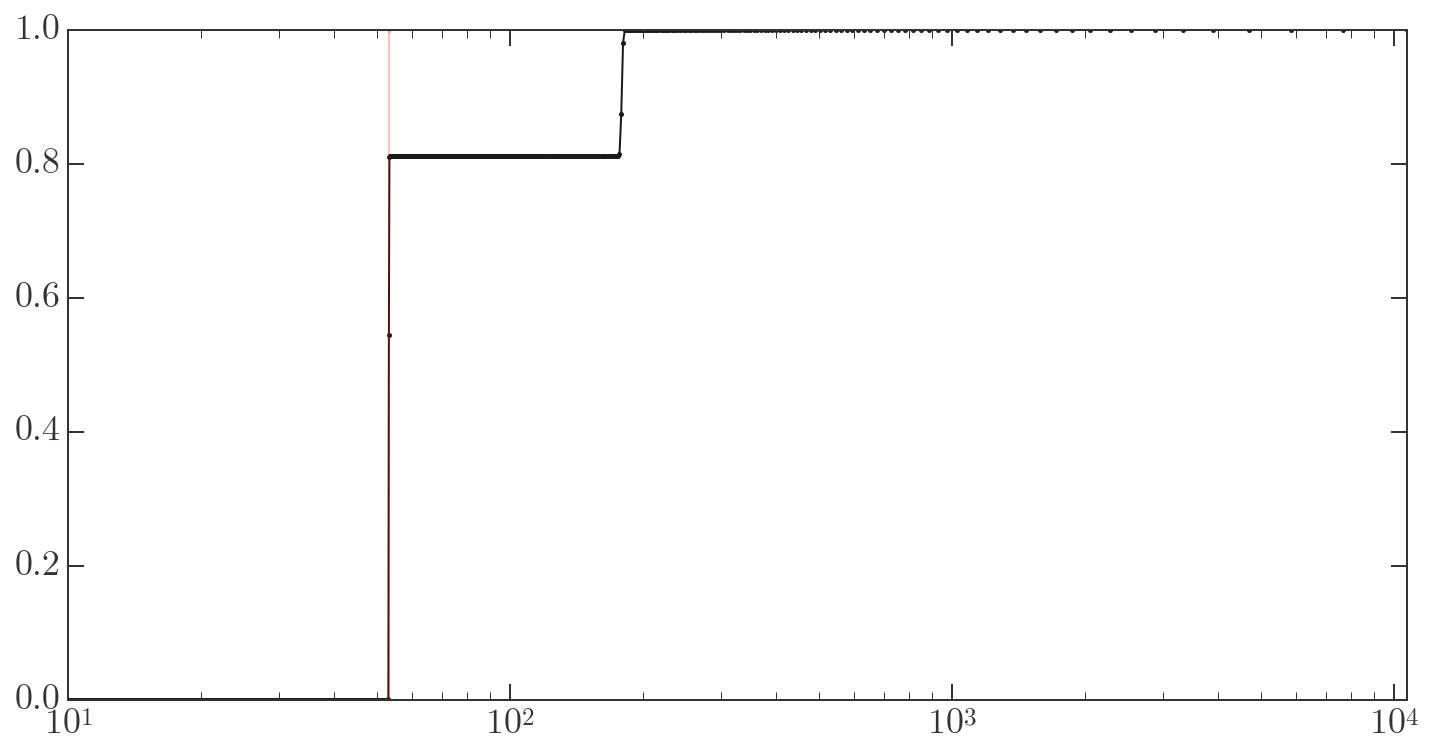

In [60]:
norm_cumsum = np.cumsum(probs) / probs.sum()

plt.figure(figsize=(12,6))
plt.semilogx(P_grid, norm_cumsum)
plt.axvline(true_P, color='r', alpha=0.25)
plt.xlim(P_grid.min(), P_grid.max())

(10.0, 10718.184509358589)

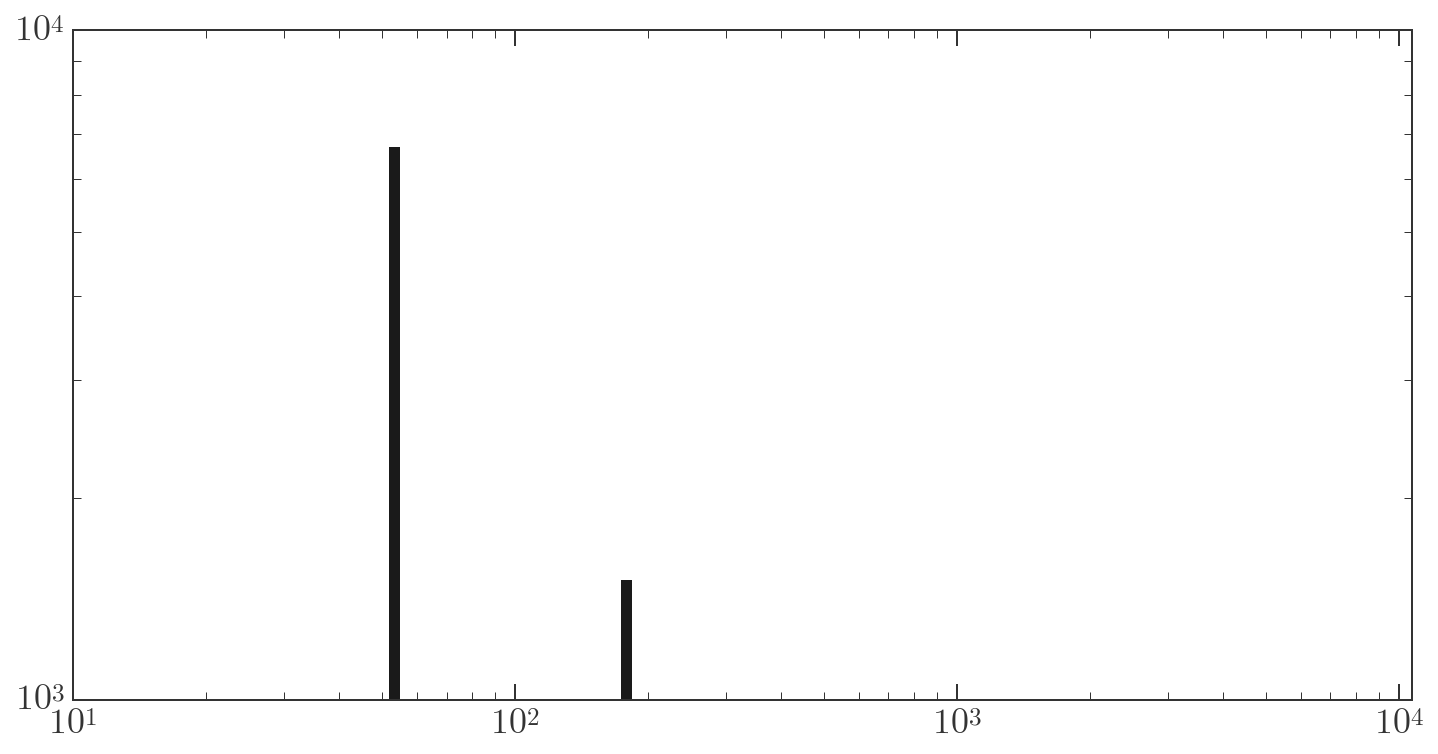

In [61]:
plt.figure(figsize=(12,6))

bins = np.logspace(np.log10(P_grid.min()), np.log10(P_grid.max()), 128)
plt.hist(sample_posterior(P_grid, probs, size=8192), bins=bins);

plt.xscale('log')
plt.yscale('log')
plt.xlim(P_grid.min(), P_grid.max())

In [62]:
def build_the_sampling(Ps, data):
    samples = np.zeros((len(Ps), 4))
    for i,P in enumerate(Ps):
        invvar,mean,_ = tensor_vector_scalar(P, data)
        cov = np.linalg.inv(invvar)
        samples[i,0] = P
        samples[i,1:] = np.random.multivariate_normal(mean, cov)    
    
    return samples

In [68]:
Ps = sample_posterior(P_grid, probs, size=32)
samples = build_the_sampling(Ps, data)

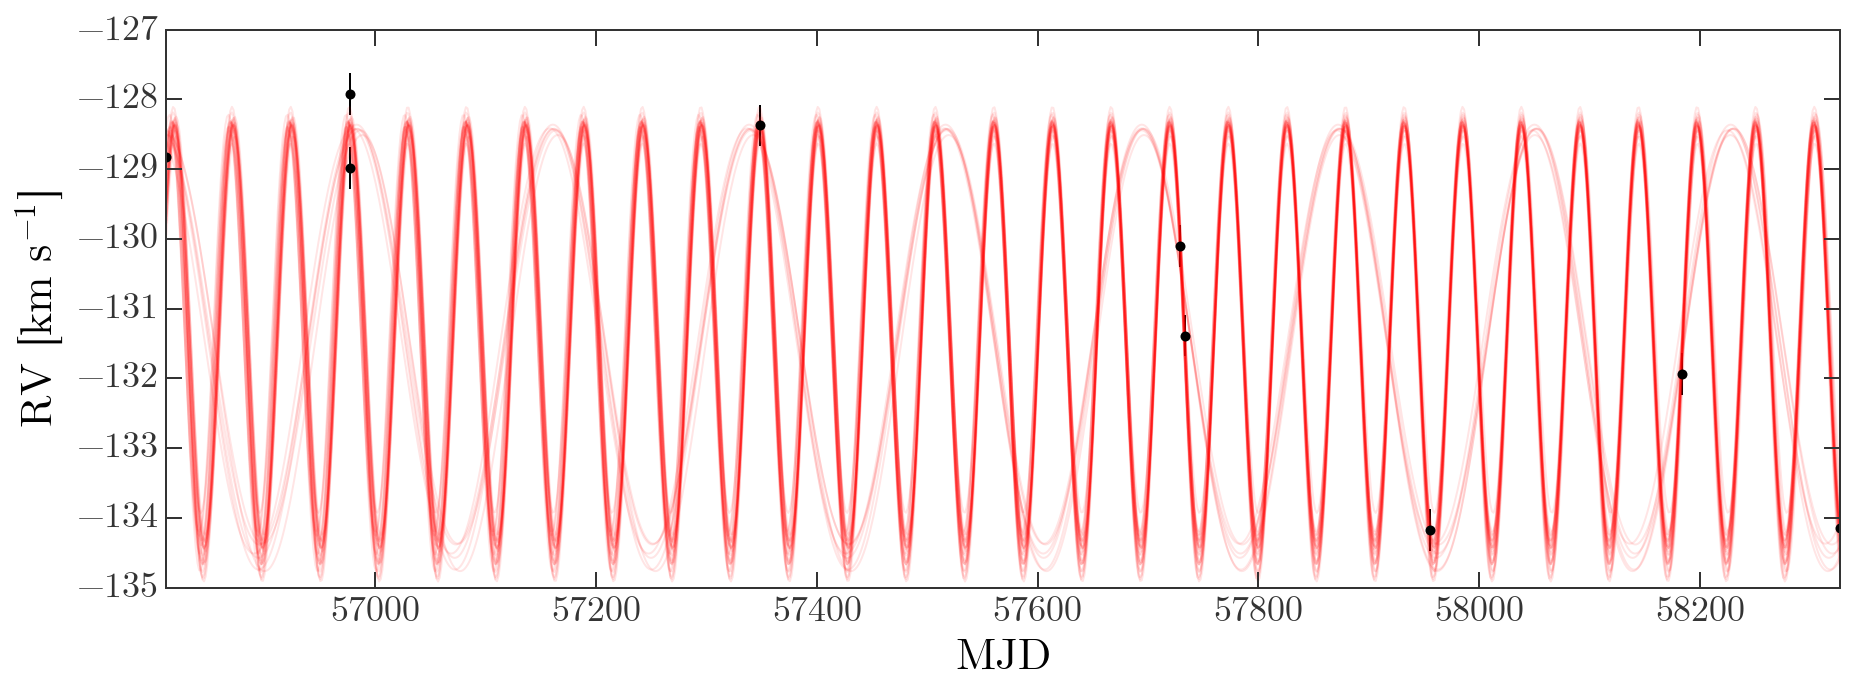

In [72]:
plt.figure(figsize=(15,5))

# plot the curve for the true model
_t = np.linspace(t.min(), t.max(), 1024)

for sample in samples:
    P,*p = sample
    model_rv = (sinusoid_model(p, _t, P)*u.au/u.day).to(u.km/u.s)
    plt.plot(_t, model_rv, marker=None, alpha=0.1, color='r')

plt.errorbar(t, rv, yerr=sigma, marker='o', linestyle='none', color='k')
plt.xlim(t.min(), t.max())
plt.xlabel('MJD')
plt.ylabel('RV [km s$^{-1}$]')

In [65]:
a1,b1 = samples[:,2:].T
Ksini = np.sqrt(a1**2 + b1**2)
asini = Ksini*samples[:,0]/(2*np.pi) # * np.sqrt(1 - ecc**2) # - is this right? might just be K
phi0 = np.arccos(a1 / Ksini)

(56810.695673796203, 58327.453749451728)

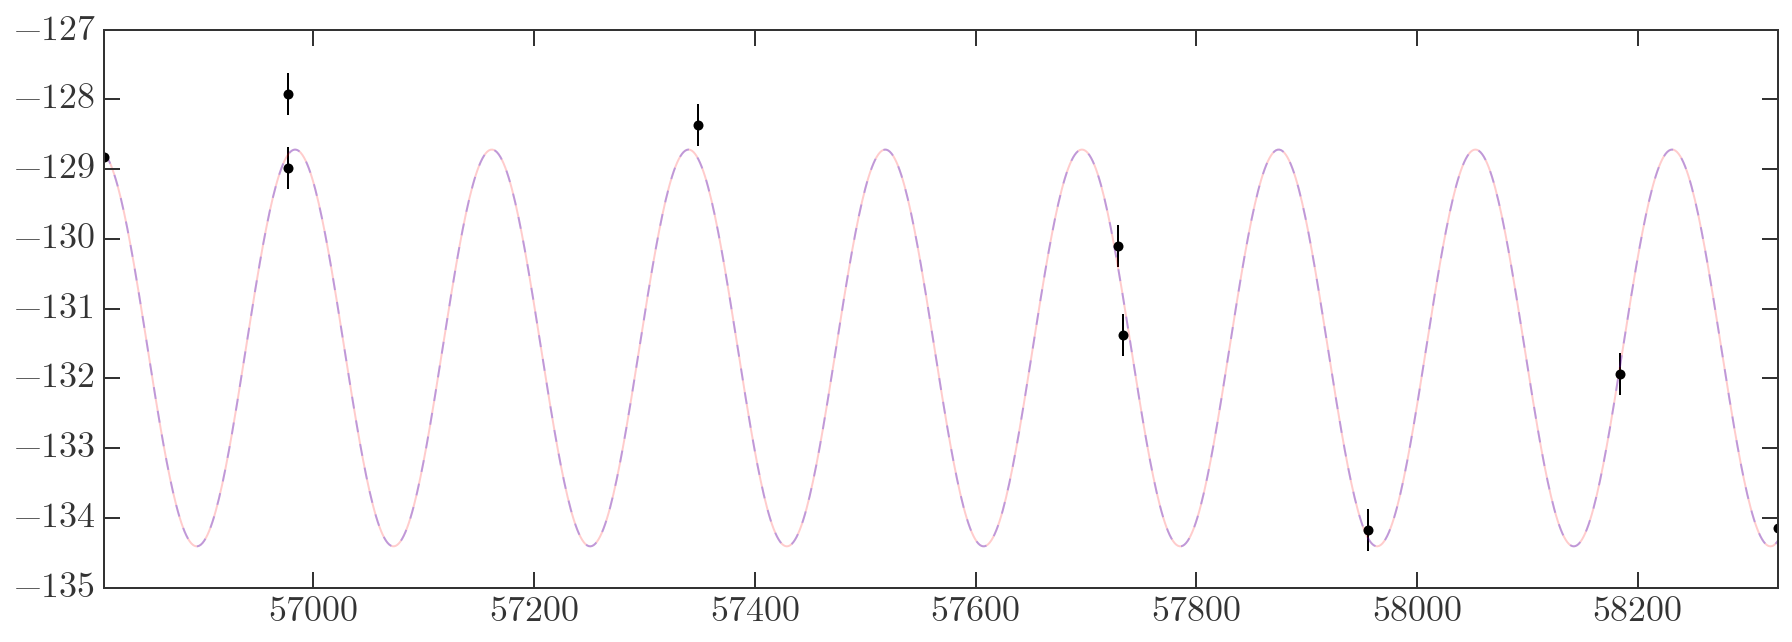

In [66]:
plt.figure(figsize=(15,5))

# plot the curve for the true model
_t = np.linspace(t.min(), t.max(), 1024)

for idx in range(5,6):
    sample = samples[idx]
    P,*p = sample
    model_rv = (sinusoid_model(p, _t, P)*u.au/u.day).to(u.km/u.s)
    plt.plot(_t, model_rv, marker=None, alpha=0.2, color='r')

    v0,a1,b1 = p
    Ksini = np.sqrt(a1**2 + b1**2)
    asini = Ksini*P/(2*np.pi) # * np.sqrt(1 - ecc**2) # - is this right? might just be K
    phi0 = np.arctan2(b1, a1)
    orbit = SimulatedRVOrbit(P*u.day, asini*u.au, ecc=0., omega=0.*u.radian, 
                             phi0=phi0*u.radian, v0=-v0*u.au/u.day)
    plt.plot(_t, orbit.generate_rv_curve(_t), linestyle='--', marker=None, alpha=0.25, color='b')

plt.errorbar(t, rv, yerr=sigma, marker='o', linestyle='none', color='k')
plt.xlim(t.min(), t.max())